# **Langchain Adaptive RAG with Llama3.1**
**未來優化方向：**
- [ ] Adaptive RAG 效果評測：**RAGAs**
- [ ] 加入 Reranker 比較檢索效果

**References**
- [利用 Langchain 實作系列 RAG 進階流程：Query Analysis & Self-reflection](https://edge.aif.tw/application-langchain-rag-advanced/)
- [使用證卷交易所API爬取股票資訊](https://hackmd.io/@aaronlife/python-ex-stock-by-api?utm_source=preview-mode&utm_medium=rec)
- [使用繁體中文評測各家 Embedding 模型的檢索能力](https://ihower.tw/blog/archives/12167)
- [LangChain 怎麼玩？ LCEL (LangChain Expression Language) 篇，一定要認識的 LangChain 核心](https://myapollo.com.tw/blog/langchain-expression-language/)
- [chromadb error example](https://www.kaggle.com/code/toddgardiner/chromadb-error-example)
- [langgraph rag agent flow](https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_rag_agent_llama3_local.ipynb)
- [solve the 'NotImplementedError' when using bind_tools with ChatOllama](https://github.com/langchain-ai/langchain/issues/21479)
- [how to create Document() object](https://github.com/langchain-ai/langgraph/blob/main/examples/tutorials/tool-calling-agent-local.ipynb)
- [differencebetween as_retriever and similarity_search](https://www.reddit.com/r/LangChain/comments/1ba77pu/difference_between_as_retriever_and_similarity/)
- [structured responses functional calling with langchain](https://medium.com/@mauryaanoop3/unleashing-structured-responses-functional-calling-with-langchain-ollama-and-phi-3-part-3-720b34203778)

## **Adaptive RAG Flow**
- `Reranker Node` 為未來優化方向，目前版本尚未加入
- Flow Reference：[Langchain 團隊的 langgraph_rag_agent_llama3_local 範例](https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_rag_agent_llama3_local.ipynb)

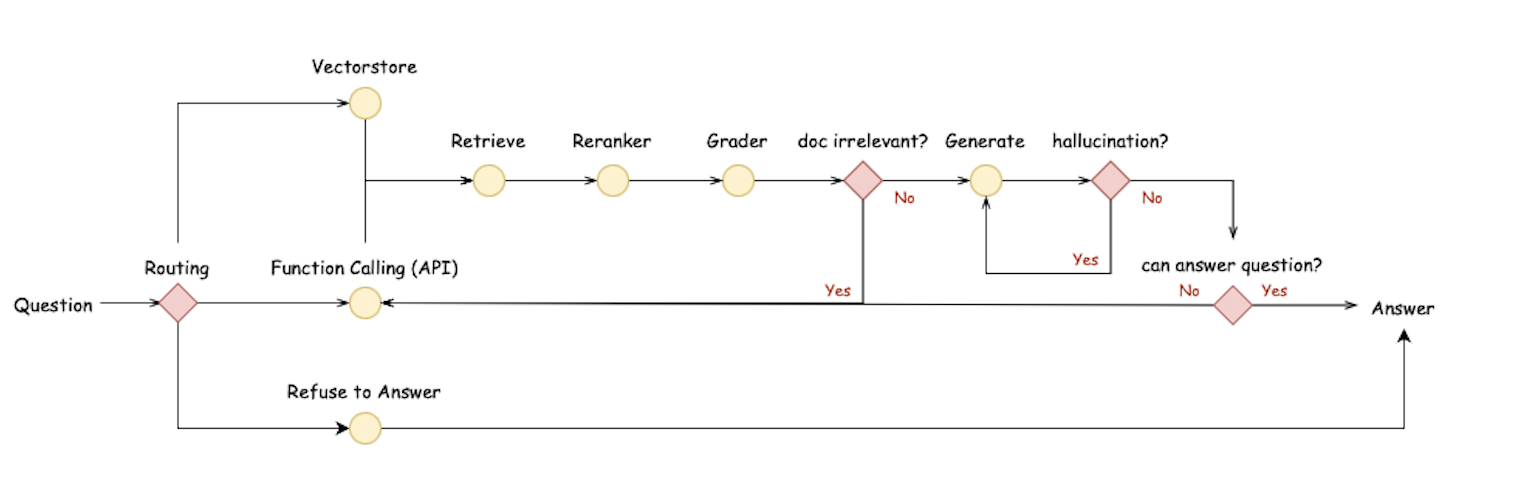



## **Data Sources**

> Below are the Data Sources in this `Langchain Adaptive RAG Chatbot`
- Vectorstore : [2024 Q2 Financial Report of TSMC (2330) download from TWSE](https://doc.twse.com.tw/server-java/t57sb01?step=1&colorchg=1&co_id=2330&year=113&seamon=&mtype=A&)
- Function Calling (API) : [TWSE Open API](https://openapi.twse.com.tw)

# **Preliminary Works**

In [ ]:
pip install -U chromadb pysqlite3-binary langchain langchain_ollama langchain_community langchain-huggingface langchain-experimental langchain-text-splitters langgraph pypdf

## **Import Packages**

In [2]:
import re
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_ollama import ChatOllama # the latest version solution to deal with `NotImplementedError`
from langchain_community.document_loaders.pdf import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain.docstore.document import Document

# function call api
import json
import time
import requests

# prompt template
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.documents import Document
from langgraph.graph import END, StateGraph

# langgraph
from langchain_core.pydantic_v1 import BaseModel, Field

# clear output and typing
from pprint import pprint
from typing import Tuple, Any, List
from typing_extensions import TypedDict

# huggingface access
from huggingface_hub import notebook_login

## **Parameters Setting**

In [ ]:
# install and import ollama package
!curl https://ollama.ai/install.sh | sh
import subprocess
process = subprocess.Popen("ollama serve", shell=True) # runs on a different thread
!pip install ollama
import ollama

In [ ]:
# download llm model
!ollama pull llama3.1:8b

In [5]:
# filepath of PDF used as the dataset of Vectorstore
filepath = "" # add the filepath of TSMC's 2024 Q2 financial report here
# top k documents retrieved from vectorstore
topk_docs = 10
# embedding model (zh)
emb_model_name = "jinaai/jina-embeddings-v2-base-zh"

### **Hugging Face Notebook Login**

**Step-by-step guideline to access Hugging Face**

1. Create a Hugging Face account.
2. Once your account is created, navigate to `MODEL_YOU_NEED` and ensure to acknowledge the license and agree to the terms.
3. Generate a new Hugging Face access token.
4. Copy the generated token.
5. When prompted, paste the token into the appropriate field.

**Reference:**

- [gemma-2b using Huggingface Transformers!!](https://www.kaggle.com/code/rumbare/gemma-2b-using-huggingface-transformers)

In [6]:
# This kernel is used to access Hugging Face account by running this kernel and entering authentication token.
# notebook_login()

## **Load PDF (the dataset of Vectorstore)**

In [7]:
# load pdf file
def load_tsmc_financial_report(filepath: str) -> list:
    loader = PyPDFLoader(
        file_path=filepath
    )
    tsmc_pdf = loader.load()
    print("load file `TSMC Q2 Financial Report` successfully.")
    return tsmc_pdf

## **Activate `Vectorstore`**
> According to the evaluation results of ihower's article [使用繁體中文評測各家 Embedding 模型的檢索能力](https://ihower.tw/blog/archives/12167), both `bge-m3` and `jina-embeddings-v2-base-zh` are open-source embedding models that perform well with **Traditional Chinese**.<br>
> However, since the latter has a smaller size, I have chosen it as the embedding model to be used here.

In [8]:
# use these three lines to overwrite sqlite3 with pysqlite3 to solve Chromadb error
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

In [9]:
%%capture 
# activate vectorstore
def activate_vectorstore(tsmc_pdf: list,
                        topk_docs: int,
                        emb_model_name: str=emb_model_name) -> Tuple[Any, list]:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=512,
        chunk_overlap=128
    )
    emb_model = HuggingFaceEmbeddings(
        model_name=emb_model_name,
        model_kwargs={"trust_remote_code":True} # prevent model from parameters being initialized
    )    
    tsmc_docs = text_splitter.split_documents(tsmc_pdf)
    for doc in tsmc_docs:
        doc.page_content = doc.page_content.replace("\n", "") # replace "\n" with ""
        doc.page_content = re.sub("\s+", " ", doc.page_content)
    vectordb = Chroma.from_documents(documents=tsmc_docs,
                                     embedding=emb_model)
    print("Vector database is ready.")
    return vectordb.as_retriever(
        search_type="similarity",
        search_kwargs={"k": topk_docs}
    ), tsmc_docs

tsmc_pdf = load_tsmc_financial_report(filepath)
vectordb, tsmc_docs = activate_vectorstore(tsmc_pdf, topk_docs)

## **Define TWSE API for `Function Calling`**

In [10]:
def post_twse_api(stocks: str):
    """
    Call the TWSE API to retrieve stock information related to the question.

    Args:
        stocks (str): All stocks that are mentioned in the question, concatenated with `|`.

    Returns:
        stock_infos (str): Stock information returned from the TWSE API, reformatted into a specific format.
    """
    # reformat stocks into a specific format required in the api url
    stock_list = []
    print("stocks =", stocks)
    for stock in stocks.split("|"):
        if re.fullmatch("^6[0-9]+", stock): # OTC Company
            stock_list.append(f"otc_{stock}.tw")
        else: # Listed Company
            stock_list.append(f"tse_{stock}.tw")
    stocks_in_url = "|".join(stock_list)
    print("stocks in url =", stocks_in_url)

    # send `get` requests
    tswe_api_url = f"http://mis.twse.com.tw/stock/api/getStockInfo.jsp?ex_ch={stocks_in_url}"
    try:
        response = requests.get(tswe_api_url)
    except Exception as e:
        print("ERROR!\nerror information is as follows:\n", e)
    data = json.loads(response.text)
    
    # get necessary information only
    infos = [("c", "股票代號"), ("n", "公司簡稱"), ("nf", "公司全稱"), ("z", "成交價"), 
             ("tv", "成交量"), ("v", "累積成交量"), ("o", "開盤價"), ("h", "最高價"), 
             ("l", "最低價"), ("y", "昨天收盤價")]
    # get metadata informations
    stock_infos = "以下為"
    for stock_msg in data["msgArray"]:
        msg = f"{stock_msg['nf']}({stock_msg['n']}, {stock_msg['c']})、"
        stock_infos += msg
    stock_infos = stock_infos[:-1] + f"截至目前 {stock_msg['^']}的最新股票相關資訊：\n\n"
    # get stock informations of each stock
    for stock_msg2 in data["msgArray"]:
        msg2 = ""
        for (code, info) in infos:
            msg2 += f"{stock_msg2['nf']}({stock_msg2['n']}, {stock_msg2['c']})的{info}:{stock_msg2[code]}\n"
        stock_infos += msg2 + "\n"
    
    return stock_infos

## **Load LLM w/Ollama**

In [11]:
# load llm (Llama3.1) using Ollama
llm = ChatOllama(model="llama3.1:8b", temperature=0)

## **Define Router**
> `Question Router`

In [12]:
# define DataModel of vector search and function calling
class vector_search(BaseModel):
    """
    This is a vector store tool that records the 2024 Q2 financial reports of TSMC (台積電, 2330). 
    If the user's question is related to the 2024 Q2 financial reports of TSMC (台積電, 2330), please use this `vector_search` tool to search for the answer.
    """
    query: str = Field(description="the question asked when searching vector store")

class function_calling_query(BaseModel):
    """
    This is a API took provided by the TWSE (Taiwan Stock Exchange, 台灣證券交易所).
    If the user's question pertains to today's stock information such as Current trading price(當前盤中成交價), Current trading volume(當前盤中成交量), Accumulated trading volume(累積成交量), Bid prices(揭示買價), Bid volumes(揭示買量), Ask prices(揭示賣價), Ask volumes(揭示賣量), Opening price(開盤價格), Highest price(最高價格), Lowest price(最低價格), Previous closing price(昨日收盤價格), Upper limit price(漲停價), Lower limit price(跌停價), Data update time(資料更新時間), Recent trading date(最近交易日期), Recent trading time(最近成交時刻), Stock code(股票代號), Company abbreviation(公司簡稱), Company full name(公司全名), please use the `function_calling` tool to find the answer.
    """
    stocks: str = Field(description="the stock symbols mentioned in the query, concatenate all stock symbols with `|`")
        
class refuse_to_answer(BaseModel):
    """
    This tool is designed to refuse to answer questions that are not related to the 2024 Q2 financial reports of TSMC (台積電, 2330) or today's stock information, such as current trading price (當前盤中成交價), current trading volume (當前盤中成交量), accumulated trading volume (累積成交量), bid prices (揭示買價), bid volumes (揭示買量), ask prices (揭示賣價), ask volumes (揭示賣量), opening price (開盤價格), highest price (最高價格), lowest price (最低價格), previous closing price (昨日收盤價格), upper limit price (漲停價), lower limit price (跌停價), data update time (資料更新時間), recent trading date (最近交易日期), recent trading time (最近成交時刻), stock code (股票代號), company abbreviation (公司簡稱), or company full name (公司全名). 
    Please use this `refuse_to_answer` tool to handle such requests.
    """
    query: str = Field(description="the question asked when the question is not related to our data range")

# system prompt
question_routing_system_prompt = """You are an expert in routing user questions to one of the following: `vector_search`, `function_calling`, or `refuse_to_answer`.
- Use the `vector_search` tool for questions related to TSMC's (台積電, 2330) 2024 Q2 financial reports.
- Use the `function_calling` tool for questions about today's stock information on the TWSE (Taiwan Stock Exchange, 台灣證券交易所), including details such as current trading price, volume, bid and ask prices, opening and closing prices, etc.
- If the question does not pertain to either subject, use the `refuse_to_answer` tool.
"""

# prompt template
question_routing_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", question_routing_system_prompt),
        ("human", "{question}"),
    ]
)

# route LLM with tool using
structured_llm_router = llm.bind_tools(tools=[vector_search, function_calling_query, refuse_to_answer])

# 使用 LCEL 語法建立 chain
question_router = question_routing_prompt | structured_llm_router

## **Define Grader**
> `Retrieval Grader` + `Hallucination Grader` + `Answer Grader`

In [13]:
# define DataModel of retrieval grader
class DocumentsGrader(BaseModel):
    """
    Check whether the retrieved document is related to the user's question or not.
    Return `yes` if it is, and `no` if it is not.
    """
    binary_score: str = Field(..., description="Is the content of document related to the user's question? (`yes` or `no`)")

# system prompt
retrieval_grader_system_prompt = """You are a reading comprehension expert. 
Your task is to read a document and determine if there is any content related to the user's question. 
If you find any relevant information, answer `yes`. If not, answer `no`.
Please focus solely on whether the document contains any relevant information to the user's question and respond with either `yes` or `no`."""

# prompt template
retrieval_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", retrieval_grader_system_prompt),
        ("human", "document:```{document}```\nuser's question:```{question}```"),
    ]
)

# llm retrieval grader
structured_llm_retrieval_grader = llm.with_structured_output(DocumentsGrader)

# build chain for retrieval grader using LCEL
retrieval_grader = retrieval_grader_prompt | structured_llm_retrieval_grader

In [14]:
# define DataModel of hallucination grader
class HallucinationGrader(BaseModel):
    """
    Check whether the AI's answer is a hallucination. 
    Return `yes` if it is, and `no` if it is not.
    """
    binary_score: str = Field(..., description="Does the AI's answer not grounded on the docments? (`yes` or `no`)")

# system prompt
hallucination_grader_system_prompt = """You are a reading comprehension expert, skilled at determining whether an AI's response is based on the content of the documents or not. 
Your task is to read both the documents and the AI's response, then decide if the information in the response comes from the documents. 
If you determine that the information in the AI's response originates from the documents, please reply `no`; otherwise, reply `yes`."""

# prompt template
hallucination_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", hallucination_grader_system_prompt),
        ("human", "documents:```{documents}```\nAI's response:```{llm_generation}```"),
    ]
)

# llm hallucination grader
structured_llm_hallucination_grader = llm.with_structured_output(HallucinationGrader)

# build chain for hallucination grader using LCEL
hallucination_grader = hallucination_grader_prompt | structured_llm_hallucination_grader

In [15]:
# define DataModel of answer grader
class AnswerGrader(BaseModel):
    """
    Check whether the AI's answer can fully address user's question or not. 
    Return `yes` if it can address user's question, and `no` if it cannot.
    """
    binary_score: str = Field(..., description="Does the AI's answer address the user's question? (`yes` or `no`)")

# system prompt
answer_grader_system_prompt = """You are an expert in reading comprehension. 
Your task is to evaluate whether the AI's response fully addresses the user's question. 
Simply respond with `yes` if the AI's answer completely solves the user's query, or `no` if it does not. 
Your answer should be based solely on whether the response fully meets the user's question. 
Just return `yes` or `no` accordingly."""

# prompt template
answer_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", answer_grader_system_prompt),
        ("human", "user's question:```{question}```\nAI's answer:```{llm_generation}```"),
    ]
)

# llm answer grader
structured_llm_answer_grader = llm.with_structured_output(AnswerGrader)

# build chain for answer grader using LCEL
answer_grader = answer_grader_prompt | structured_llm_answer_grader

## **Define RAG Chain**

In [16]:
# system prompt (use CoT, chain of thought)
rag_system_prompt = """You are a question-answering expert skilled at answering users' questions based on retrieved documents.
Please note that if you cannot answer the user's question using the documents, you should directly reply with `查無資訊`.
Hallucinations will be penalized.
Please answer in Traditional Chinese and double-check your answer for accuracy.
Let's think step by step."""

# prompt template
rag_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", rag_system_prompt),
        ("system", "documents:\n```{documents}```"),
        ("human", "user's question: {question}"),
    ]
)

# build chain for rag question-answering using LCEL
rag_chain = rag_prompt | llm | StrOutputParser()

# **Construct LangGraph**

## **Define `Graph State`**

In [17]:
# use graph state to record the information shared among graph nodes
class GraphState(TypedDict):
    """
    State of graph.

    Attributes:
        question: question
        documents: list of documents
        llm_generation: LLM generation
    """
    question : str
    documents : List[str]
    llm_generation : str

## **Define Search Tools**
> `Vector Search` + `Function Calling` + `Refuse to Answer`

In [27]:
def vector_search(state):
    """
    Retrieve documents related to the question.

    Args:
        state (dict): The current state graph

    Returns:
        state (dict): New key added to state, documents containing list of related documents.
    """
    print("--- VECTOR SEARCH ---")
    question = state["question"]
    documents = vectordb.invoke(question)
    return {
        "question":question, 
        "documents":documents
    }

def function_calling(state):
    """
    function calling based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended function calling results
    """
    print("--- FUNCTION CALLING ---")
    question = state["question"]
    documents = state["documents"] if state["documents"] else []
    structured_llm_for_stocks = llm.with_structured_output(function_calling_query)
    structured_output = structured_llm_for_stocks.invoke(question)
    stock_infos = post_twse_api(structured_output.stocks)
    api_doc =  [Document(page_content=stock_infos, metadata={"source": "TWSE_API"})]
    documents = documents + api_doc
#     print(documents)
    return {
        "question":question, 
        "documents": documents
    }

def refuse_to_answer(state):
    """
    Refuse to answer the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains predetermined answer
    """
    print("--- REFUSE TO ANSWER---")
    question = state["question"]
    return {"question": question, "llm_generation": "不好意思，您的問題已超出我的知識範圍，我可能無法回答您。請詢問與台積電 2024 Q2 財務報表相關或與台灣今日股價資訊相關的問題。"}

## **Define Nodes**

In [28]:
def grade_retrieval(state):
    """
    filter retrieved documents based on question.

    Args:
        state (dict): The current state graph

    Returns:
        state (dict): New key added to state, documents containing list of related documents.
    """
    print("--- CHECK IF DOCUMENTS RELATED TO QUESTION ---")
    question = state["question"]
    documents = state["documents"]
    filtered_docs = []
    for doc in documents:
#         print(doc.page_content)
        retrieval_score = retrieval_grader.invoke(
            {
                "question": question, 
                "document": doc.page_content
            }
        )
#         print(retrieval_score)
        retrieval_grade = retrieval_score.binary_score
        if retrieval_grade == "yes":
            print("> GRADE RESULT : DOCUMENT IS RELATED TO QUESTION :)")
            filtered_docs.append(doc)
        else:
            print("> GRADE RESULT : DOCUMENT IS NOT RELATED TO QUESTION :(")
            continue
    return {
        "question": question,
        "documents": filtered_docs
    }

def rag_generate(state):
    """
    Generate answer using  vectorstore / web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("--- GENERATE ANSWER IN RAG MODE ---")
    question = state["question"]
    documents = state["documents"]
    llm_generation = rag_chain.invoke(
        {
            "question": question,
            "documents": documents
        }
    )
    return {
        "question": question,
        "documents": documents,  
        "llm_generation": llm_generation
    }

## **Define Conditional Edges**

In [34]:
def route_question(state):
    """
    Route question to Vector Seaerch (RAG) or Function Calling.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    print("--- ROUTE QUESTION ---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    # raise error if no decision
    if len(source.tool_calls) == 0: # here is different from `ChatOpenAI`
        raise "Question router could not decide source."
    # choose datasource
    datasource = source.tool_calls[0]["name"]
    if datasource == 'vector_search':
        print("> DECISION : ROUTE TO 'VECTOR SEARCH'")
        return "vector_search"
    elif datasource == 'function_calling':
        print("> DECISION : ROUTE TO 'FUNCTION CALLING'")
        return "function_calling"
    else:
        print("> DECISION : ROUTE TO 'REFUSE TO ANSWER'")
        return "refuse_to_answer"

def route_retrieval(state):
    """
    Determines whether to generate an answer, or use function calling.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("--- ROUTE RETRIEVAL ---")
    filtered_documents = state["documents"]
    if not filtered_documents:
        # all documents have been filtered check_relevance
        print("> RETRIEVAL ROUTER DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, ROUTE TO FUNCTION CALLING.")
        return "function_calling"
    else:
        # we have relevant documents, so generate answer
        print("> RETRIEVAL ROUTER DECISION: GENERATE WITH LLM RAG.")
        return "rag_generate"

def grade_rag_generation(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("--- CHECK HALLUCINATIONS ---")
    question = state["question"]
    documents = state["documents"]
    llm_generation = state["llm_generation"]
#     print(documents, llm_generation)
    hallucination_score = hallucination_grader.invoke(
        {
            "documents": documents, 
            "llm_generation": llm_generation
        }
    )
    hallucination_grade = hallucination_score.binary_score
    # check hallucination
    if hallucination_grade == "no":
        print("> HALLUCINATION GRADER DECISION: GENERATION IS GROUNDED IN DOCUMENTS.")
        # check question-answering
        print("--- GRADE GENERATION vs QUESTION ---")
        answer_score = answer_grader.invoke(
            {
                "question": question,
                "llm_generation": llm_generation
            }
        )
        answer_grade = answer_score.binary_score
        if answer_grade == "yes":
            print("> ANSWER GRADER DECISION: GENERATION ADDRESSES QUESTION.")
            return "useful"
        else:
            print("> ANSWER GRADER DECISION: GENERATION DOES NOT ADDRESS QUESTION.")
            return "not useful"
    else:
        print("> HALLUCINATION GRADER DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY.")
        return "not supported"

## **Build Graph**

In [35]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("function_calling", function_calling) # function calling
workflow.add_node("vector_search", vector_search) # vector search
workflow.add_node("refuse_to_answer", refuse_to_answer) # refuse to answer
workflow.add_node("grade_retrieval", grade_retrieval) # grade retrieval
workflow.add_node("rag_generate", rag_generate) # rag

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "function_calling": "function_calling",
        "vector_search": "vector_search",
        "refuse_to_answer": "refuse_to_answer"
    },
)
workflow.add_edge("vector_search", "grade_retrieval")
workflow.add_edge("function_calling", "grade_retrieval")
workflow.add_conditional_edges(
    "grade_retrieval",
    route_retrieval,
    {
        "function_calling": "function_calling",
        "rag_generate": "rag_generate",
    },
)
workflow.add_conditional_edges(
    "rag_generate",
    grade_rag_generation,
    {
        "not supported": "rag_generate", # Hallucinations: re-generate
        "not useful": "function_calling", # Fails to answer question: fall-back to function calling
        "useful": END,
    },
)
workflow.add_edge("refuse_to_answer", END)

# Compile
app = workflow.compile()

# **Run Adaptive RAG**

In [36]:
def run_adaptive_rag(question):
    inputs = {"question": question}
    for output in app.stream(inputs, {"recursion_limit": 5}): # can only retry one of any process 2 times
        print("\n")
    # Final generation
    if 'rag_generate' in output.keys():
        print(output['rag_generate']['llm_generation'])
    elif 'refuse_to_answer' in output.keys():
        print(output['refuse_to_answer']['llm_generation'])
    else:
        raise ValueError(f"The style of final answer should be `rag_generate`, but something different `{output.keys()}` is returned.")

In [37]:
%%capture --no-stdout
# DEMO `VECTOR SEARCH`
question = "台積電在113年第一季收回了多少股的未既得之限制員工權利新股？"
run_adaptive_rag(question)

--- ROUTE QUESTION ---
[GIN] 2024/08/27 - 16:08:28 | 200 |   2.20426141s |       127.0.0.1 | POST     "/api/chat"
> DECISION : ROUTE TO 'VECTOR SEARCH'
--- VECTOR SEARCH ---


--- CHECK IF DOCUMENTS RELATED TO QUESTION ---
[GIN] 2024/08/27 - 16:08:30 | 200 |  1.227259798s |       127.0.0.1 | POST     "/api/chat"
> GRADE RESULT : DOCUMENT IS NOT RELATED TO QUESTION :(
[GIN] 2024/08/27 - 16:08:31 | 200 |  966.313919ms |       127.0.0.1 | POST     "/api/chat"
> GRADE RESULT : DOCUMENT IS NOT RELATED TO QUESTION :(
[GIN] 2024/08/27 - 16:08:32 | 200 |  981.203928ms |       127.0.0.1 | POST     "/api/chat"
> GRADE RESULT : DOCUMENT IS RELATED TO QUESTION :)
[GIN] 2024/08/27 - 16:08:33 | 200 |  904.928446ms |       127.0.0.1 | POST     "/api/chat"
> GRADE RESULT : DOCUMENT IS NOT RELATED TO QUESTION :(
[GIN] 2024/08/27 - 16:08:34 | 200 |  1.015043034s |       127.0.0.1 | POST     "/api/chat"
> GRADE RESULT : DOCUMENT IS NOT RELATED TO QUESTION :(
[GIN] 2024/08/27 - 16:08:34 | 200 |   923.6287

In [38]:
%%capture --no-stdout
# DEMO `FUNCTION CALLING`
question2 = "台股旺宏2337跟台積電2330今天的成交價分別是多少？"
run_adaptive_rag(question2)

--- ROUTE QUESTION ---
[GIN] 2024/08/27 - 16:10:04 | 200 |  1.677728416s |       127.0.0.1 | POST     "/api/chat"
> DECISION : ROUTE TO 'FUNCTION CALLING'
--- FUNCTION CALLING ---
[GIN] 2024/08/27 - 16:10:05 | 200 |  979.122509ms |       127.0.0.1 | POST     "/api/chat"
stocks = 2337|2330
stocks in url = tse_2337.tw|tse_2330.tw


--- CHECK IF DOCUMENTS RELATED TO QUESTION ---
[GIN] 2024/08/27 - 16:10:09 | 200 |  1.444268319s |       127.0.0.1 | POST     "/api/chat"
> GRADE RESULT : DOCUMENT IS RELATED TO QUESTION :)
--- ROUTE RETRIEVAL ---
> RETRIEVAL ROUTER DECISION: GENERATE WITH LLM RAG.


--- GENERATE ANSWER IN RAG MODE ---
[GIN] 2024/08/27 - 16:10:11 | 200 |  2.273713963s |       127.0.0.1 | POST     "/api/chat"
--- CHECK HALLUCINATIONS ---
[GIN] 2024/08/27 - 16:10:15 | 200 |  4.025445005s |       127.0.0.1 | POST     "/api/chat"
> HALLUCINATION GRADER DECISION: GENERATION IS GROUNDED IN DOCUMENTS.
--- GRADE GENERATION vs QUESTION ---
[GIN] 2024/08/27 - 16:10:16 | 200 |  943.84396

In [25]:
%%capture --no-stdout
# DEMO `REFUSE TO ANSWER`
question3 = "請問台股手續費怎麼算？"
run_adaptive_rag(question3)

--- ROUTE QUESTION ---
[GIN] 2024/08/27 - 15:47:25 | 200 |  1.666583582s |       127.0.0.1 | POST     "/api/chat"
> DECISION : ROUTE TO 'REFUSE TO ANSWER'
--- REFUSE TO ANSWER---


不好意思，您的問題已超出我的知識範圍，我可能無法回答您。請詢問與台積電 2024 Q2 財務報表相關或與台灣今日股價資訊相關的問題。
